This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1504
Number of nonzeros in inequality constraint Jacobian.:      560
Number of nonzeros in Lagrangian Hessian.............:      600

Total number of variables............................:      650
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      424
Total number of inequality constraints...............:      320
        inequality constraints with only lower bounds:      160
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      160

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Text(0, 0.5, 'hand speed [m/s]')

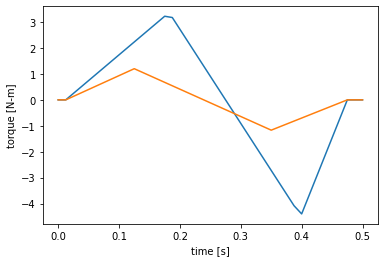

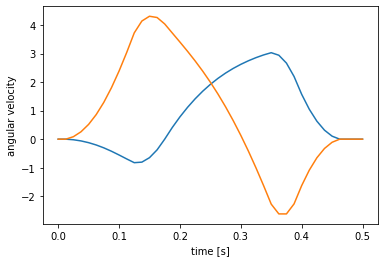

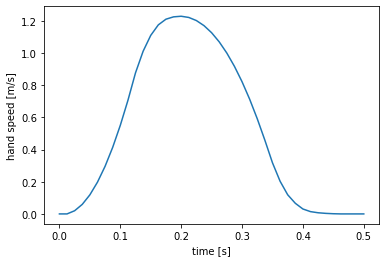

In [2]:
# %%
# arm model
# ----------------------
# An optimal control problem (OCP),
# solved with direct multiple-shooting.
# based off of race-car.
# For more information see: http://labs.casadi.org/OCP

import sys
import numpy as np
import casadi as ca
from getModelConstraintErrors import getModelConstraintErrors
from Integrators import eulerIntegrator
import matplotlib.pyplot as plt
import getJointKinematics as jk

N = 40 # number of control intervals
opti = ca.Opti() # optimization problem

# ---- problem parameters ---------
#g  =  9.81            # gravity
l1  =  0.3            # upper arm
l2  =  0.3            # lower arm
m1 = 1               # upper arm mass
m2 = 1               # lower arm mass
i1 = 1/12*m1*(l1)**2
i2 = 1/12*m1*(l2)**2

# % Model: dynamics written implicitly.
f_getModelConstraintErrors = getModelConstraintErrors(
    l1, l2, m1, m2, i1, i2)

# ---- decision variables ---------
q = opti.variable(10,N+1) # state trajectories (6), force (2), force rate (2)
u = opti.variable(6,N  ) # control vars force rate rate (2), power and frate rate coneq
q1 = q[0,:] # shoulder angle
q2 = q[1,:] # elbow angle
q1dot = q[2,:] # dq1dt 
q2dot = q[3,:] # dq2dt
q1dotdot = q[4,:] # ddq1dt2 
q2dotdot = q[5,:] # ddq2t2

tauSho = q[6,:] #shoulder torque
tauElb = q[7,:] #elbow torque
dtau1 = q[8,:] #shoulder torque d/dt
dtau2 = q[9,:] #elbow torque d/dt

ddtau1 = u[0,:] # shoulder frr
ddtau2 = u[1,:] # elb frr
pSho  = u[2,:] # pos s power; slack variable
pElb  = u[3,:] # pos e power; slack variable
pddT1 = u[4,:] # pos frr; slack variable
pddT2 = u[5,:] # pos frr; slack variable
#TFinal = opti.variable()      # final time
TFinal = 0.5
dt = TFinal/N # length of a control interval

# ---- dynamic constraints --------

# provide the derivatives for all using implicit formulation of the constraints. 
for k in range(N): # loop over control intervals
   
    # Stack states at mesh points k and k+1.
    #               sho      elb       dsho,     delb,     tausho   tauelb   dtausho  dtauelb     
    Xk = ca.vertcat(q[0,k],  q[1,k],   q[2,k],   q[3,k],   q[6,k],  q[7,k],  q[8,k],  q[9,k])
    Xk_plus = ca.vertcat(
                    q[0,k+1],q[1,k+1], q[2,k+1], q[3,k+1], q[6,k+1], q[7,k+1],q[8,k+1],q[9,k+1])
    # Stack state derivatives.
    Uk_plus = ca.vertcat(
                    q[2,k+1],q[3,k+1], q[4,k+1], q[5,k+1], q[8,k+1], q[9,k+1],u[0,k],  u[1,k])

    # Path constraints - dynamic constraints.
    opti.subject_to(eulerIntegrator(Xk, Xk_plus, Uk_plus, dt) == 0)
    modelConstraintErrors = f_getModelConstraintErrors(
      q[0,k],q[1,k],
      q[2,k],q[3,k],
      q[4,k],q[5,k],
      q[6,k],q[7,k])
    opti.subject_to(ca.vertcat(*modelConstraintErrors) == 0)
    powerSho = q[6,k] * q[2,k]
    powerElb = q[7,k] * q[3,k]


    
    opti.subject_to(pSho[:,k] >= powerSho)
    opti.subject_to(pElb[:,k] >= powerElb)

# slack variable
opti.subject_to(pddT1 >= ddtau1)
opti.subject_to(pddT2 >= ddtau2)

# compute objective
coefMargaria = 4.8
coefFR = 5e-2 
J = 0      
for k in range(1,N):
    J = J + coefMargaria*(pSho[:,k] +pSho[:,k-1])/2*dt + (pElb[:,k] +pElb[:,k-1])/2*dt + coefFR*((pddT1[:,k]+pddT1[:,k-1])/2)*dt + ((pddT2[:,k]+pddT2[:,k-1])/2)*dt

#slack constraints
opti.subject_to(pSho >= 0.0)
opti.subject_to(pElb >= 0.0)
opti.subject_to(pddT1 >= 0.0)
opti.subject_to(pddT2 >= 0.0)


# ---- objective ------------------
opti.minimize(J) # minimize objective function

# # ---- boundary conditions --------
#opti.subject_to(TFinal >=0)
opti.subject_to(q1[0] == 0.1)
opti.subject_to(q2[0] == 0.1)
opti.subject_to(q1[-1] == 0.1+25/180*np.pi)
opti.subject_to(q2[-1] == 0.1+25/180*np.pi)

opti.subject_to(q1dot[0] == 0.0)
opti.subject_to(q2dot[0] == 0.0)
opti.subject_to(q1dot[-1] == 0.0)
opti.subject_to(q2dot[-1] == 0.0)

opti.subject_to(q1dotdot[0] == 0.0)
opti.subject_to(q2dotdot[0] == 0.0)
opti.subject_to(q1dotdot[-1] == 0.0)
opti.subject_to(q2dotdot[-1] == 0.0)

opti.subject_to(tauSho[0] == 0.0)
opti.subject_to(tauElb[0] == 0.0)
opti.subject_to(tauSho[-1] == 0.0)
opti.subject_to(tauElb[-1] == 0.0)
opti.subject_to(dtau1[0] == 0.0)
opti.subject_to(dtau2[0] == 0.0)
opti.subject_to(ddtau1[0] == 0.0)
opti.subject_to(ddtau2[0] == 0.0)
opti.subject_to(dtau1[-1] == 0.0)
opti.subject_to(dtau2[-1] == 0.0)
opti.subject_to(ddtau1[-1] == 0.0)
opti.subject_to(ddtau2[-1] == 0.0)


# ---- solve NLP -------------------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve

print("complete")

from matplotlib import pyplot as plt
#% plot the results

time = np.linspace(0,TFinal,N+1)
plt.figure()
plt.plot(time, sol.value(tauSho))
plt.plot(time,sol.value(tauElb))
plt.ylabel("torque [N-m]")
plt.xlabel("time [s]")
plt.figure()
plt.plot(time,sol.value(q1dot),label="q1dot")
plt.plot(time,sol.value(q2dot),label="q2dot")
plt.ylabel("angular velocity")
plt.xlabel("time [s]")

q1_sol = sol.value(q1)
q2_sol = sol.value(q2)
q_sol = sol.value(q[:2,:])
dqdt_sol = sol.value(q[2:4,:])

q1dot_sol = sol.value(q1dot)
q2dot_sol = sol.value(q2dot)

tv = np.ndarray([len(q1_sol)]) 
hv = np.ndarray([2,len(q1_sol)]) 
for i in range(0,len(q1_sol)):
    Jac = np.matrix([[-l1*np.sin(q1_sol[i]), -l2*np.sin(q2_sol[i])],[l1*np.cos(q1_sol[i]), l2*np.cos(q2_sol[i])]])
    dqdt = np.matrix([[q1dot_sol[i]],[q2dot_sol[i]]])
    temp = Jac*dqdt
    hv[0,i] = temp[0,0] 
    hv[1,i] = temp[1,0] 
    tv[i] = np.sqrt(hv[0,i]**2+hv[1,i]**2)

tvs = np.ndarray([1,dqdt_sol.shape[1]])
for i in range(0,q_sol.shape[1]):
    tvs[:,i] = jk.handSpeed(q_sol[:,i],dqdt_sol[:,i],l1,l2) 

plt.figure()
plt.plot(time,np.transpose(tvs))
plt.xlabel("time [s]")
plt.ylabel("hand speed [m/s]")

# %%

